# Arquitectura LeNet-5 Fashion-MNIST
# Incluye uso de Regularización con Dropout, L2 y L1.


In [0]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from sklearn.metrics import classification_report
import time
from sklearn.metrics import confusion_matrix
import sklearn.model_selection as model_selection
from keras import regularizers

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train,y_train),(x_testg,y_testg) = fashion_mnist.load_data()

In [36]:
print(x_train.shape)
print(x_testg.shape)
print(y_train.shape)
print(y_testg.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


# Partición en Train - Val - Test

In [37]:
idx = np.random.permutation(x_testg.shape[0])
x_testg = x_testg[idx]
y_testg = y_testg[idx]
print(x_testg.shape)
print(y_testg.shape)
print()

(10000, 28, 28)
(10000,)



In [0]:
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_testg, y_testg, train_size=0.80,test_size=0.20)

In [39]:
print(x_val.shape)
print(x_test.shape)
print(y_val.shape)
print(y_test.shape)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


In [0]:
dicc = {0:"T_shirt",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",
          5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle_boot"}

{0: 'T_shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle_boot'}


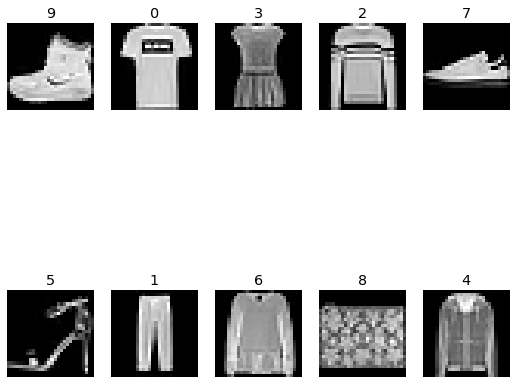

In [41]:
print(dicc)
cc = [0,1,3,5,6,8,21,18,23,28]  # un ejemplo de cada clase/objeto.
fig=plt.figure(figsize=(9,9)) # figure size, inches
k=1
for i in cc:
  fig.add_subplot(2, 5, k)
  plt.imshow(x_train[i], cmap='gray')
  plt.title(y_train[i])
  plt.axis('off')
  k += 1

In [0]:
x_train, x_val, x_test = x_train/255.0, x_val/255.0, x_test/255.0

In [43]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [0]:
ytrain = tf.keras.utils.to_categorical(y_train)
yval = tf.keras.utils.to_categorical(y_val)
ytest = tf.keras.utils.to_categorical(y_test)

In [45]:
ytrain

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
labels = ["T_shirt","Trouser","Pullover","Dress","Coat",
          "Sandal","Shirt","Sneaker","Bag","Ankle_boot"]

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_val = x_val.reshape(x_val.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

In [48]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(8000, 28, 28, 1)
(2000, 28, 28, 1)


LeNet-5 model:


In [0]:
model = tf.keras.models.Sequential([

   #C1 - feature maps - Convolutional layer:
   #tf.keras.layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
   # L1 & L2:
   tf.keras.layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu',
                          #kernel_regularizer=regularizers.l1(0.01)),
                          #kernel_regularizer=regularizers.l2(0.01)),
                          kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),

   tf.keras.layers.BatchNormalization(axis = -1),
   tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
   
   # Regularización en Bloques: -- En este caso es mejor no usarlo en los bloques.
   #tf.keras.layers.Dropout(0.25),

   #C3 - Convolutional layer:
   #tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'),
   tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid',
                          kernel_regularizer=regularizers.l2(0.01)),
   tf.keras.layers.BatchNormalization(axis = -1,),
   tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
   
   # Regularización en Bloques:
   #tf.keras.layers.Dropout(0.25),

   tf.keras.layers.Flatten(),

   #C5 - Full connection:
   #tf.keras.layers.Dense(120, activation='tanh'),
   tf.keras.layers.Dense(120, activation='tanh',
                         kernel_regularizer=regularizers.l2(0.01)),

   #BN:
   tf.keras.layers.BatchNormalization(axis = -1),
   
   # Regularización en Capas de Salida: -- un buen valor es 0.3
   tf.keras.layers.Dropout(0.3),

   #FC-6 - Fully connected layer:
   #tf.keras.layers.Dense(84, activation='tanh'),
   tf.keras.layers.Dense(84, activation='tanh',
                         kernel_regularizer=regularizers.l2(0.01)),

   #Output   
   tf.keras.layers.Dense(10,activation=tf.nn.softmax)
   ])

In [0]:
n_epochs=5
n_batch=32
learning_rate=0.01

Learning Rate - Exponencial Decay - lr = lr0 * exp( - k * t )

In [0]:
def exp_decay(epoch):
  alfa_0 = 0.001
  factor = 0.001
  dropEvery = 4

  alfa = alfa_0 * np.exp( - factor * np.floor(epoch/dropEvery) )

  return float(alfa)

In [0]:
callbacks_list = [tf.keras.callbacks.LearningRateScheduler(exp_decay)]

In [0]:
opt = tf.keras.optimizers.SGD(lr=learning_rate, decay=learning_rate / n_epochs, momentum=0.9, nesterov=True )

In [0]:
model.compile(optimizer=opt, 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [55]:
H = model.fit(x_train,ytrain, validation_data=(x_val,yval),
              epochs=n_epochs, batch_size=n_batch)
              #epochs=n_epochs, batch_size=n_batch, callbacks=callbacks_list)

Epoch 1/5
1875/1875 [==============================] - 56s 30ms/step - loss: 1.2239 - accuracy: 0.8249 - val_loss: 0.7197 - val_accuracy: 0.8246
Epoch 2/5
1875/1875 [==============================] - 55s 30ms/step - loss: 0.5526 - accuracy: 0.8624 - val_loss: 0.5332 - val_accuracy: 0.8561
Epoch 3/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.4752 - accuracy: 0.8721 - val_loss: 0.4471 - val_accuracy: 0.8780
Epoch 4/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.4413 - accuracy: 0.8785 - val_loss: 0.4529 - val_accuracy: 0.8683
Epoch 5/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.4233 - accuracy: 0.8801 - val_loss: 0.4302 - val_accuracy: 0.8737


Una vez entrenado el modelo, ya podemos salvarlo para futuras predicciones:


In [0]:
predictions = model.predict(x_val, batch_size=n_batch)

In [57]:
print(predictions[0])

[2.2058685e-04 5.3509852e-05 1.1766797e-04 1.9557156e-04 1.4209421e-04
 3.1185438e-04 1.0784164e-04 9.9656975e-01 8.0714672e-05 2.2004521e-03]


In [0]:
#score = model.evaluate(x_test, ytest, verbose=0, batch_size=n_batch)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  156       
_________________________________________________________________
batch_normalization_3 (Batch multiple                  24        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  2416      
_________________________________________________________________
batch_normalization_4 (Batch multiple                  64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                 

In [0]:
#print(model.non_trainable_weights)

In [61]:
print(classification_report(yval.argmax(axis=1),
      predictions.argmax(axis=1),target_names=labels))

              precision    recall  f1-score   support

     T_shirt       0.85      0.78      0.81       810
     Trouser       0.99      0.98      0.98       797
    Pullover       0.83      0.78      0.81       800
       Dress       0.91      0.89      0.90       800
        Coat       0.84      0.70      0.76       790
      Sandal       0.98      0.97      0.97       807
       Shirt       0.57      0.76      0.65       811
     Sneaker       0.93      0.97      0.95       791
         Bag       0.98      0.96      0.97       797
  Ankle_boot       0.98      0.95      0.96       797

    accuracy                           0.87      8000
   macro avg       0.88      0.87      0.88      8000
weighted avg       0.88      0.87      0.88      8000



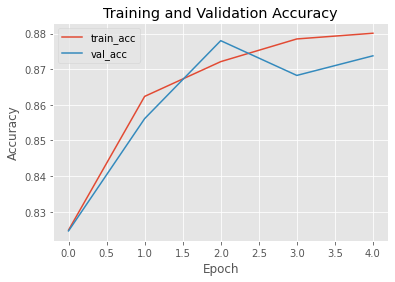

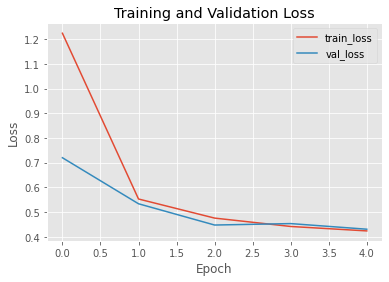

In [62]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,n_epochs),H.history["val_accuracy"],label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss") 
plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [63]:
confusion_matrix(yval.argmax(axis=1), predictions.argmax(axis=1))

array([[634,   0,  11,   9,   4,   3, 145,   0,   4,   0],
       [  0, 778,   1,  10,   2,   0,   4,   0,   2,   0],
       [  9,   0, 626,   8,  50,   0, 107,   0,   0,   0],
       [ 14,   6,   6, 709,  14,   0,  49,   0,   2,   0],
       [  1,   1,  60,  30, 551,   0, 147,   0,   0,   0],
       [  0,   0,   0,   0,   0, 782,   0,  21,   0,   4],
       [ 92,   0,  46,   9,  37,   1, 619,   0,   7,   0],
       [  0,   0,   0,   0,   0,   7,   0, 769,   0,  15],
       [  0,   0,   5,   3,   1,   3,  14,   5, 766,   0],
       [  0,   0,   0,   0,   0,   4,   1,  36,   0, 756]])

Predicciones en el conjunto de prueba: Test set

In [0]:
predictions_test = model.predict(x_test, batch_size=n_batch)

In [65]:
print(classification_report(ytest.argmax(axis=1),
      predictions_test.argmax(axis=1),target_names=labels))

              precision    recall  f1-score   support

     T_shirt       0.88      0.76      0.82       190
     Trouser       0.97      0.98      0.97       203
    Pullover       0.82      0.80      0.81       200
       Dress       0.86      0.84      0.85       200
        Coat       0.80      0.69      0.74       210
      Sandal       0.99      0.98      0.98       193
       Shirt       0.56      0.75      0.64       189
     Sneaker       0.94      0.98      0.96       209
         Bag       0.98      0.97      0.97       203
  Ankle_boot       0.97      0.95      0.96       203

    accuracy                           0.87      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000



In [66]:
confusion_matrix(ytest.argmax(axis=1), predictions_test.argmax(axis=1))

array([[145,   1,   3,   4,   1,   0,  35,   0,   1,   0],
       [  0, 199,   0,   3,   0,   0,   1,   0,   0,   0],
       [  0,   0, 160,   2,  15,   0,  23,   0,   0,   0],
       [  2,   4,   1, 169,   9,   0,  15,   0,   0,   0],
       [  0,   1,  21,   9, 144,   0,  34,   0,   1,   0],
       [  0,   0,   0,   1,   0, 189,   0,   3,   0,   0],
       [ 17,   0,  10,   8,  11,   0, 141,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0, 204,   0,   5],
       [  1,   1,   1,   0,   1,   1,   2,   0, 196,   0],
       [  0,   0,   0,   0,   0,   1,   0,   9,   0, 193]])